##### Auteur  : Mamoudou KOUME
#### Data scientist student

### L'objectif de ce mini-projet est d'appliquer la régression de faible rang dans le cas de données simulées dans un premier temps. Par la suite, il s'agira de faire de l'apprentissage multi-tâches (multivariée ici) accompagné de régularisation

##### Mots-clés : régression de faible rang, régression multivariée, régularisation (ridge, lasso, multitasklasso)

## I- Régresion de rang faible sur des données simulées

On cherche ici à faire la régression multivariée de rang faible; c'est à dire $f(x) = w^Tx$, avec $x_i \in \mathbb{R^d}$, $y_i \in \mathbb{R^p}$ et $W \in \mathbb{R^d_p}$. Le $\hat{W}$ qu'on cherche est solution du problème de minimisation suivant : $\hat{W} = \frac{1}{n} \vert \vert Y - XW\vert \vert^2$ sous contraintes que le rang de $W$ soit inférieur à certain rang $r$ i.e $W$ est une une matrice de rang faible.

On peut dès générer des données de sorte à voir une matrice de taille $d \times p$ de rang r. Prenons par exemple $d = 15$, $p = 16$ et $r = 2$.

(15, 16)
2


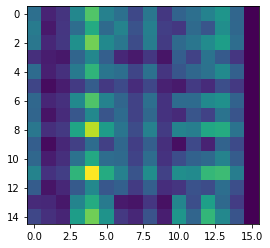

In [3]:
# Chargement des librairies nécessaires
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# On va construire w à l'aide de deux matrices A et B telque w = AB

# On crée la matrice A de dimension 4x5
A = np.random.rand(30).reshape(15, 2)

# On crée deux matrices B1 et B2 de dimension 5x2
B1 = np.random.rand(30).reshape(2, 15)
B2 = np.full((2, 1), 0)

# On obtient la matrice B par concaténation des matrices B1 et B2 sur le premier axe
# de sorte à avoir
B = np.concatenate([B1, B2], axis=1)

# La matrice w obtenu en faisant le produit des matrices A et B sera de rang inférieur ou égal à 2
w = A.dot(B)
print(w.shape)

# On vérifie que w est de rang 2
print(np.linalg.matrix_rank(w))

#  Affichage de la matrice w avec la commande imshow
plt.imshow(w)

Maintenant qu'on vient de créer la matrice $W$ de faible rang, on peut dès à présent des données d'apprentissage $\{(x_i,y_i), i=1,\ldots,n\}$ suivant le modèle $y_i = Wx_i + \epsilon_i$.


In [5]:
# On génère X de dimension nx15 et epsilon de dimension nx16

n_examples = 100 # nombre d'exemples d'apprentissage
sigma = 0.3  # écart-type du bruit
x = np.random.rand(15 * n_examples).reshape(n_examples, 15) * 10
eps = np.random.randn(16 * n_examples).reshape(n_examples, 16) 
y = x.dot(w) + eps * sigma
print(y.shape)

(100, 16)


Nous allons par la suite implémenter la méthode de régression de faible rang. Cette dernière prend pour paramètres $X$, $Y$ et $r$. Vous pouvez voir qu'on a fixé ici $r$ à 2 pour faire simple mais on pouvait générer une matrice $W$ de rang quelconque et appliquer la régression de rang faible. Le choix du rang sera à notre portée dans ce cas.

In [6]:
# Partition en données d'apprentissage et données test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Définition de la fonction de régression de rang faible
def regressionrangfaible(X, Y, rang):

        XTX = np.dot(X.T, X) 
        XTY = np.dot(X.T, Y) 
        W_etoile = np.dot(np.linalg.pinv(XTX), XTY)             # Calcul de la solution OLS
        Y_etoile = np.dot(X, W_etoile)                          # Prédictions de Y OLS
        U, D, VT = np.linalg.svd(Y_etoile, full_matrices=False) # Calcul de la SVD de Y_etoile
        Y_etoile_remake = (U @ np.diag(D) @ VT)                 # reconstruction de y en utlisant U,D,VT
        P = np.dot(VT[0:rang, :].T, VT[0:rang, :])              # Calcul de la matrice de projection Pr
        W_chap_etoile = np.dot(W_etoile, P)                     # Calcul de la solution de faible rang
        return W_etoile, P, W_chap_etoile                       # Solution LS, rang faible et matrice de Projection

# full_matrices = False si Y_etoile n'est pas carrée mais rectangulaire
# full_matrices = True si Y_etoile est carrée

# W_etoile est la solution LS.
# W_chap_etoile est la solution de la regression de faible rang.
# Pr est la matrice de projection

# On applique maintenant la fonction aux données d'apprentissage avec un rang égal à 2 (puisqu'on a w qui est de rang 
# inférieur ou égal à 2)

W_LS, Pr, Wr = regressionrangfaible(X_train, y_train, 2) 

# On vérifie bien que Pr est une matrice de projection
Pcarre = np.dot(Pr, Pr)
print(np.allclose(Pcarre, Pr)) #renvoie true si c'est le cas et false dans le cas contraire

# On vérifie que les dimensions sont bien correctes
print(W_LS.shape)
print(Pr.shape)
print(Wr.shape)

True
(15, 16)
(16, 16)
(15, 16)


Evaluons les performances de prédiction de la régression de faible rang sur un jeu de données test et comparons les résultats avec la régression par moindres carrés (LS).

In [8]:
# Définition de la fonction qui prédit Y à partir de X avec la régression de rang faible

def prediction(X):
        """
        Predire Y à partir de X.
        """
        return np.dot(X, np.dot(Wr, Pr))  

In [10]:
# Prédiction avec W_LS et Wr

yr = prediction(X_test) # prédiction avec la méthode de la régression de rang faible
y_LS = X_test @ W_LS    # prédiction avec la méthode des moindres carrés (LS)

# Pour comparer les résutats des modèles, on peut comaparer leurs MSE et MAE

MSE_LS = mean_squared_error(y_test, y_LS)
MSE_r = mean_squared_error(y_test, yr)
MAE_LS = mean_absolute_error(y_test, y_LS)
MAE_r = mean_absolute_error(y_test, yr)

# Affichage des MSE et MAE

print('Mean Squared Error de la régression LS : ', MSE_LS)
print('Mean Squared Error de la régression de faible rang : ', MSE_r)
print('Mean Absolute Error de la régression LS : ', MAE_LS)
print('Mean Absolute Error de la régression de faible rang : ', MAE_r)

# Conclusion : Les MSE et MAE obtenus avec la régression de rang faible sont plus petits que ceux obtenus avec la
# méthode LS. Ce qui laisse dire que la méthode de rang faible est plus performante que celle des moindres carrés.

Mean Squared Error de la régression LS :  0.10094387549022117
Mean Squared Error de la régression de faible rang :  0.0896077223250143
Mean Absolute Error de la régression LS :  0.2575453642231722
Mean Absolute Error de la régression de faible rang :  0.24029385774897152


## II- Apprenissage multivariée et régularisation